In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Create DataFrame from keyboard_actions.log

Log file is formatted as a csv file so pd.read_csv works like a charm

Indexed by timestamp of each action (should always be unique)

In [145]:
keyboard_df = pd.read_csv("logs/Zirui/keyboard_actions.log", names=['time', 'key', 'action'])

keyboard_df

,time,key,action
0,7.2376,'w',pressed
1,7.6604,'a',pressed
2,7.8563,'a',released
3,9.0524,'a',pressed
4,9.4064,'a',released
...,...,...,...
3575,670.2026,'a',released
3576,673.8301,Key.cmd,pressed
3577,674.1170,Key.tab,pressed
3578,674.2703,Key.tab,released


### Create DataFrame from mouse_actions.log

same deal

In [146]:
mouse_df = pd.read_csv("logs/Zirui/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])

mouse_df

,time,x,y,button,action
0,0.0968,452,334,left,released
1,0.2963,452,335,None,None
2,0.2993,452,336,None,None
3,0.3005,453,336,None,None
4,0.3026,453,337,None,None
...,...,...,...,...,...
184105,677.4316,424,358,None,None
184106,677.4376,424,357,None,None
184107,677.4476,424,356,None,None
184108,677.4606,424,354,None,None


## Generate heatmap from mouse positions

In [210]:
# Instantiate this class using a DataFrame (parsed log file)
class MouseHeatmap:
    def __init__(self, mouse_df):
        self.df = mouse_df
        self.last_time, self.last_x, self.last_y = 0, 0, 0

        # Screen dimensions according to log min/max values
        self.screen_w_log = np.max(self.df.x) - np.min(self.df.x)
        self.screen_h_log = np.max(self.df.y) - np.min(self.df.y)

        # Use 1080p dimesnions if larger log file dimensions
        self.screen_w, self.screen_h = max(1920, self.screen_w_log), max(1080, self.screen_h_log)

        # Define heatmap dimensions and create empty 2D array (zeros)
        self.heatmap_w, self.heatmap_h = 100, 100
        self.heatmap_values = np.zeros((self.heatmap_w, self.heatmap_h))

        # Saturation value used in normalization
        self.saturation = 5

    # Add a line of data to the heatmap (in List form)
    # Uses the passed line to find duration that the mouse was in the last position
    # Adds previous line of data (from last function call) to heat map and prepares the passed line
    def to_heatmap(self, line):
        # Find duration of mouse in last position
        value = line[0] - self.last_time
        # Add last line of data to heatmap
        self.heatmap_values[self.last_x, self.last_y] += value

        # Prepare passed line of data for heatmap
        self.last_time = line[0]

        # Normalize and clamp data if needed
        x_raw, y_raw = line[1], line[2]
        x = int((x_raw / self.screen_w) * (self.heatmap_w - 1))
        y = int((y_raw / self.screen_h) * (self.heatmap_h - 1))
        if x < 0: x = 0
        if x > (self.heatmap_w - 1): x = self.heatmap_w - 1
        if y < 0: y = 0
        if y > (self.heatmap_h - 1): y = self.heatmap_h - 1
        self.last_x, self.last_y = x, y

    # Show the heatmap generated from a specified minute of activity
    # Fails if minute is beyond the length of log file (TODO: fix this)
    def show_minute(self, min, res=(100, 100)):
        # Refresh heatmap (reset to zeros)
        self.heatmap_values = np.zeros(res)
        self.heatmap_w, self.heatmap_h = res[0], res[1]

        # Reset values
        self.last_time, self.last_x, self.last_y = 0, 0, 0

        # Calculate first and last second of minute
        last_sec = min * 60.0
        first_sec = last_sec - 60.0

        # Create a mask for specified minute
        df_mask = (self.df.time > first_sec) & (self.df.time < last_sec)

        # Iterate through each row of dataframe within specified minute
        for i in self.df[df_mask].index:
            line = self.df.iloc[i].values.tolist() # Convert row to List
            self.to_heatmap(line)

        # Normalize heatmap values (divide by max value)
        self.heatmap_values /= np.max(self.heatmap_values) 

        # Compress the heatmap
        # Calculate max saturation = (mean / deviation) * (1 / saturation)
        threshold = self.heatmap_values.mean() / (self.heatmap_values.std() * self.saturation)
        # Anything above max_saturation is clamped to max_saturation
        self.heatmap_values[self.heatmap_values > threshold] = threshold

        # Show heatmap
        plt.figure(figsize=(10, 10))
        plt.imshow(self.heatmap_values.T, cmap='cividis') # Need to transpose array to represent screen
        plt.show()

    def get_minute(self, min, res=(100, 100)):
        # Refresh heatmap (reset to zeros)
        self.heatmap_values = np.zeros(res)
        self.heatmap_w, self.heatmap_h = res[0], res[1]

        # Reset values
        self.last_time, self.last_x, self.last_y = 0, 0, 0

        # Calculate first and last second of minute
        last_sec = min * 60.0
        first_sec = last_sec - 60.0

        # Create a mask for specified minute
        df_mask = (self.df.time > first_sec) & (self.df.time < last_sec)

        # Iterate through each row of dataframe within specified minute
        for i in self.df[df_mask].index:
            line = self.df.iloc[i].values.tolist() # Convert row to List
            self.to_heatmap(line)

        # Normalize heatmap values (divide by max value)
        self.heatmap_values /= np.max(self.heatmap_values) 

        # Compress the heatmap
        # Calculate threshold = (mean / deviation) * (1 / saturation)
        threshold = self.heatmap_values.mean() / (self.heatmap_values.std() * self.saturation)
        # Anything above threshold is clamped to threshold
        self.heatmap_values[self.heatmap_values > threshold] = threshold

        return self.heatmap_values.T

    @staticmethod
    def show_heatmap(heatmap):
        # Show heatmap
        plt.figure(figsize=(10, 10))
        plt.imshow(heatmap, cmap='cividis')
        plt.show()

    @staticmethod
    def show_heatmap_centered(heatmap):
        # Find center values by averaging the indices of the max 10 column/row sums
        x_center = int(np.mean(np.argsort(heatmap.sum(axis=0))[::-1][:10]))
        y_center = int(np.mean(np.argsort(heatmap.sum(axis=1))[::-1][:10]))

        # Find variance by index of first non-zero value - index of last non-zero value
        # Then divide in half
        x_variance = int(np.trim_zeros(np.trim_zeros(heatmap.sum(axis=0), 'f'), 'b').size / 2)
        y_variance = int(np.trim_zeros(np.trim_zeros(heatmap.sum(axis=1), 'f'), 'b').size / 2)

        # Choose largest variance value (so heatmap is 1:1 ratio)
        variance = max(x_variance, y_variance)

        # Zoom in a little
        variance = int(variance * 0.8)

        x_min = max(x_center - variance, 0)
        x_max = x_center + variance
        y_min = max(y_center - variance, 0)
        y_max = y_center + variance

        MouseHeatmap.show_heatmap(heatmap[y_min:y_max, x_min:x_max])


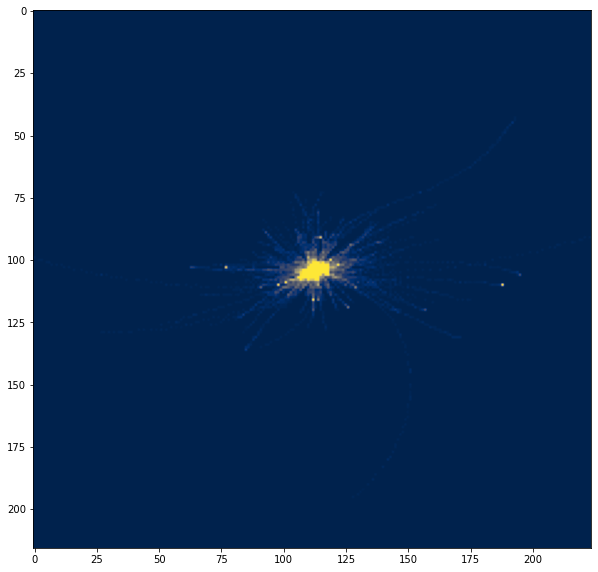

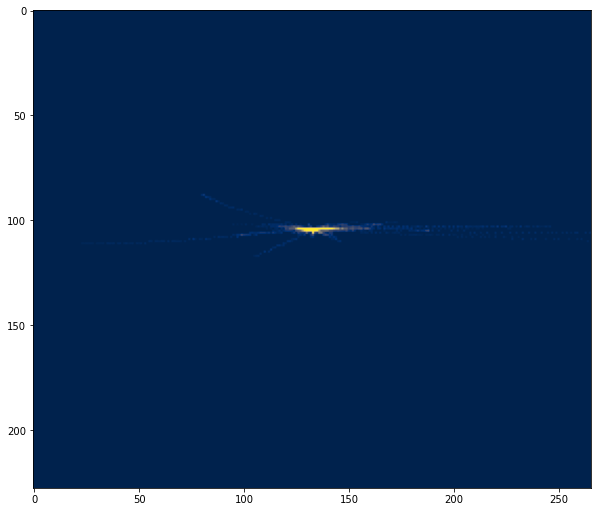

In [212]:
jon_mouse_df = pd.read_csv("logs/Jonathan/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])
zirui_mouse_df = pd.read_csv("logs/Zirui/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])

heatmap_jon = MouseHeatmap(jon_mouse_df)
heatmap_zirui = MouseHeatmap(zirui_mouse_df)

heatmap_zirui = heatmap_zirui.get_minute(2, res=(500, 500))
heatmap_jon = heatmap_jon.get_minute(2, res=(500, 500))
MouseHeatmap.show_heatmap_centered(heatmap_jon)
MouseHeatmap.show_heatmap_centered(heatmap_zirui)

## Generate heatmap from keyboard activities

In [27]:
#Keyboard log parser
class keyboardLogParser:
    @staticmethod
    def parseKeyboardLog(inputPath, outputPath, startMin, endMin):
        # The 49 default key bindings for team fortress 2
        keyBindings = ["w","a","s","d","Key.space","Key.ctrl_l","'","/","Key.up","Key.down",
                    "v","y","u","z","x","c",",",".","m","n","Key.f2","Key.f3","l","g",
                    "h","i","f","b","-","r","q","1","2","3","4","5","6","7","8","9","0",
                    "t","Key.tab","Key.f5","Key.f6","Key.f7","`","j","k"]
        #starMin and endMin must >= 0
        resultDict = {} # containing 'key':[last press time, last action, total duration, freq]
        start = float(startMin * 60)
        end = float(endMin * 60)

        # ReadFile
        file1 = open(inputPath, 'r')
        lines = file1.readlines()
        #Calculate duration and freq for each key between startMin and endMin
        for line in lines:
            line = line.replace("'", "")
            line = line.strip()
            words = line.split(",")
            time = float(words[0])
            key = words[1]
            if key in keyBindings:
                time = float(words[0])
                if time <= end:
                    if time >= start:
                        action = words[2]
                        if key in resultDict:
                            if resultDict[key][1] == "pressed":
                                if action == "released":
                                    newDura = time - resultDict[key][0]
                                    resultDict[key][2] += newDura
                                    resultDict[key][1] = action
                                    resultDict[key][3] += 1
                            else:
                                    if action == "pressed":
                                        resultDict[key][0] = time
                                        resultDict[key][1] = action
                        else:
                            if action == "pressed":
                                resultDict[key] = [time,action,0,0]
                else:
                    break

        #Write result to output file
        file2 = open(outputPath,'w')

        for key in resultDict:
            totalDura = resultDict[key][2]
            freq = resultDict[key][3]
            avgDura = totalDura/freq
            output = key +" "+ str("{:.5f}".format(avgDura)) +" "+ str(freq)
            print(output, file=file2)

In [33]:
class keyboadrHeatmap:
    def __init__(self, keyboard_df, maxF, maxD):
        # The 49 default key bindings for team fortress 2
        self.keyBindings = ["w","a","s","d","Key.space","Key.ctrl_l","'","/","Key.up","Key.down",
                    "v","y","u","z","x","c",",",".","m","n","Key.f2","Key.f3","l","g",
                    "h","i","f","b","-","r","q","1","2","3","4","5","6","7","8","9","0",
                    "t","Key.tab","Key.f5","Key.f6","Key.f7","`","j","k"]
        keyFreqDict ={}
        keyDuraDict = {}
        self.maxFreq = maxF
        self.maxDura = maxD
        for key in self.keyBindings:
            keyFreqDict[key] = 0
            keyDuraDict[key] = 0
        theKeyboardDict = keyboard_df.to_dict('records')
        for item in theKeyboardDict:
            keyFreqDict[item['key']] = item['freq']
            keyDuraDict[item['key']] = item['avg_duration']
        self.keyFreqList = []
        self.keyDuraList = []
        for item in self.keyBindings:
            if item in keyFreqDict:
                self.keyFreqList.append(keyFreqDict[item])
            else:
                self.keyFreqList.append(0)
            if item in keyDuraDict:
                self.keyDuraList.append(keyDuraDict[item])
            else:
                self.keyDuraList.append(0)
        self.arrFreq = np.array([self.keyFreqList])
        self.arrDura = np.array([self.keyDuraList])

    @staticmethod
    def show_heatmap(heatmap):
        # Setting up the heatmap
        fig, axes = plt.subplots( nrows=2)
        ax1,ax2 = axes
        im1 = ax1.imshow(heatmap.arrFreq, cmap='cividis', vmax=heatmap.maxFreq)
        im2 = ax2.imshow(heatmap.arrDura, cmap='cividis', vmax=heatmap.maxDura)
        plt.subplots_adjust(top=0.1, bottom=0)


        ax1.set_xticks(np.arange(len(heatmap.keyBindings)))
        ax1.set_yticks(np.arange(len(['Frequency'])))
        ax2.set_xticks(np.arange(len(heatmap.keyBindings)))
        ax2.set_yticks(np.arange(len(['Average Duraion'])))

        ax1.set_xticklabels(heatmap.keyBindings)
        ax1.set_yticklabels(['Frequency'])
        ax2.set_xticklabels(heatmap.keyBindings)
        ax2.set_yticklabels(['Average Duraion'])
        # Rotate the tick labels and set their alignment.
        plt.setp(ax1.get_xticklabels(), rotation=20, ha="right")
        plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
        for i in range(len(heatmap.keyBindings)):
            text = ax1.text(i,0, heatmap.keyFreqList[i], ha='center')
            text = ax2.text(i,0, heatmap.keyDuraList[i], ha='center')
        ax1.set_title("Frequency")
        ax2.set_title("Average Duration")
        fig.set_size_inches(40,30)
        fig.suptitle("Frequency and average duartion pressed for keys", fontsize=16, ha='center', va='top', x=0.5, y= 0.12)
        fig.tight_layout

        # Show heatmaps for frequency and average duartion pressed for keys
        plt.show()



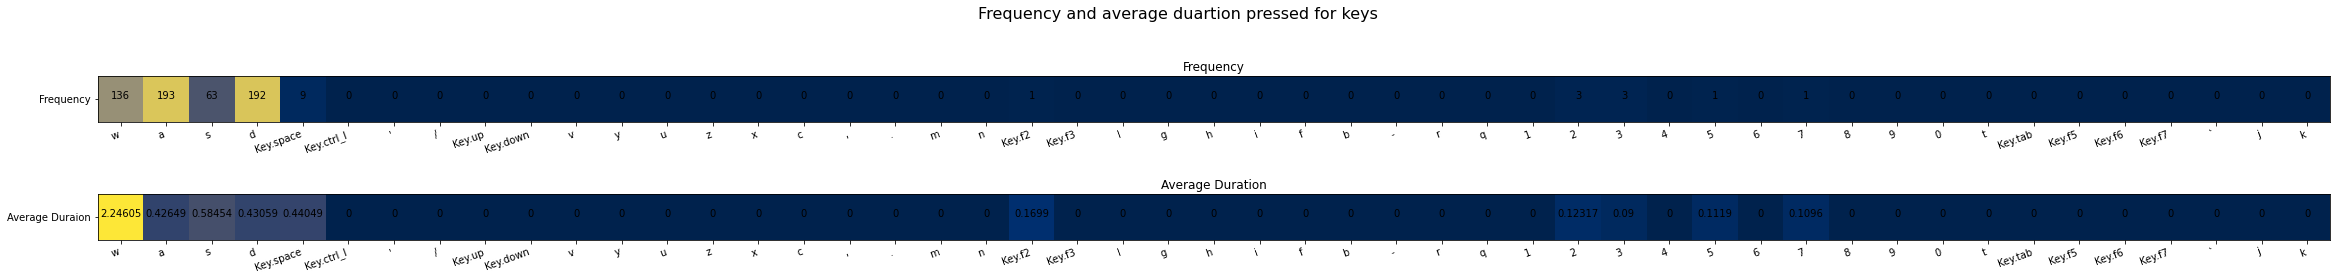

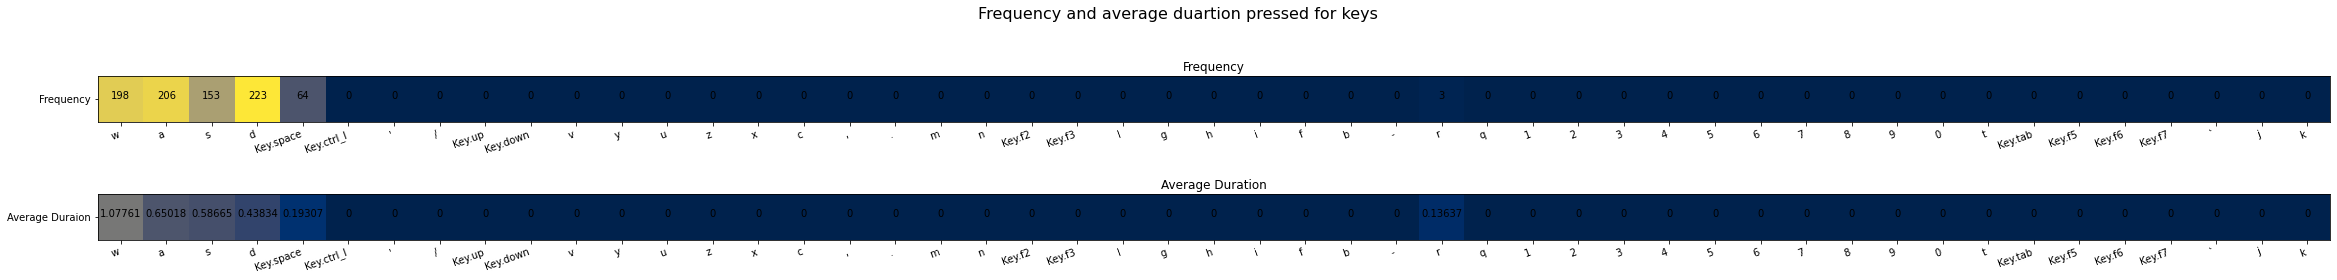

In [35]:
#Known issue: The size of input files are different, need to separate logfiles into 10~20min segments

# Getting the data from  parsed input keyboard log file
#                 parseKeyboardLog(inputPath, outputPath, startMin, endMin):
keyboardLogParser.parseKeyboardLog("keyboard_actions_jon_spy_nov8.log","JonFreqDura.log",0,10)
keyboardLogParser.parseKeyboardLog("Zirui_Keyboard.log","ZiruiFreqDura.log",0,10)
Jon_keyboardDurationAndFreq_df = pd.read_csv("JonFreqDura.log",delimiter=" ", names=['key', 'avg_duration', 'freq'])
Zirui_keyboardDurationAndFreq_df = pd.read_csv("ZiruiFreqDura.log",delimiter=" ", names=['key', 'avg_duration', 'freq'])
#Need to calculate max vlaue for color bar before showing heatmap
keyboardInputList = []
keyboardInputList.append(Jon_keyboardDurationAndFreq_df)
keyboardInputList.append(Zirui_keyboardDurationAndFreq_df)
maxFreq = 0
maxDura = 0
for keyboardInput in keyboardInputList:
    maxF = np.max(keyboardInput.freq)
    maxD = np.max(keyboardInput.avg_duration)
    if maxF > maxFreq:
        maxFreq = maxF
    if maxD > maxDura:
        maxDura = maxD
keyboadrheatmapJon = keyboadrHeatmap(Jon_keyboardDurationAndFreq_df,maxFreq,maxDura)
keyboadrheatmapZirui = keyboadrHeatmap(Zirui_keyboardDurationAndFreq_df,maxFreq,maxDura)
keyboadrHeatmap.show_heatmap(keyboadrheatmapJon)
keyboadrHeatmap.show_heatmap(keyboadrheatmapZirui)